# Análisis del Presupuesto del Sector Público de Chile

Este notebook realiza un análisis detallado del Proyecto de Ley de Presupuestos del Sector Público, utilizando datos obtenidos a través de la API de datos.gob.cl. El análisis incluye:

1. Exploración de la estructura jerárquica del presupuesto
2. Análisis de distribución de montos por niveles
3. Identificación de principales partidas y sus características
4. Visualizaciones avanzadas de la distribución presupuestaria

## Configuración Inicial

In [1]:
# Importación de librerías necesarias
import urllib.request
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Configuración de visualización
plt.style.use('default')
plt.rcParams['figure.figsize'] = (12, 6)
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda x: '{:,.0f}'.format(x) if abs(x) >= 1 else '{:,.2f}'.format(x))

In [2]:
def consultar_api(url):
    """
    Realiza una consulta a la API de datos.gob.cl y retorna los resultados en formato JSON
    
    Args:
        url (str): URL completa de la API incluyendo parámetros
        
    Returns:
        dict: Respuesta de la API en formato JSON
    """
    try:
        headers = {
            'User-Agent': 'Mozilla/5.0',
            'Accept': 'application/json'
        }
        request = urllib.request.Request(url, headers=headers)
        
        with urllib.request.urlopen(request) as response:
            for encoding in ['utf-8', 'latin1', 'iso-8859-1']:
                try:
                    datos = response.read()
                    return json.loads(datos.decode(encoding))
                except UnicodeDecodeError:
                    continue
                except json.JSONDecodeError as e:
                    print(f"Error al decodificar JSON: {e}")
                    return None
            
            print("No se pudo decodificar la respuesta con ninguna codificación conocida")
            return None
            
    except Exception as e:
        print(f"Error al consultar la API: {type(e).__name__} - {str(e)}")
        return None

def analizar_nivel(df, nivel, min_monto=1000):
    """
    Analiza la distribución de montos por nivel jerárquico
    
    Args:
        df (DataFrame): DataFrame con los datos del presupuesto
        nivel (str): Nombre de la columna del nivel a analizar
        min_monto (int): Monto mínimo a considerar
        
    Returns:
        DataFrame: Resumen del análisis por nivel
    """
    resumen = df.groupby(nivel)['Monto Pesos'].agg(['sum', 'count']).reset_index()
    resumen.columns = [nivel, 'Monto Total', 'Cantidad Items']
    return resumen[resumen['Monto Total'] >= min_monto].sort_values('Monto Total', ascending=False)

def visualizar_distribucion_nivel(df, nivel, top_n=10):
    """
    Crea una visualización de la distribución de montos para un nivel específico
    
    Args:
        df (DataFrame): DataFrame con los datos del presupuesto
        nivel (str): Nombre de la columna del nivel a visualizar
        top_n (int): Número de elementos top a mostrar
    """
    resumen = analizar_nivel(df, nivel)
    
    plt.figure(figsize=(12, 6))
    sns.barplot(data=resumen.head(top_n), 
                x=nivel, y='Monto Total',
                palette='viridis')
    plt.title(f'Top {top_n} {nivel.capitalize()} por Monto Total')
    plt.xticks(rotation=45, ha='right')
    plt.ylabel('Monto Total (Pesos)')
    plt.tight_layout()
    plt.show()
    
    print(f"\nEstadísticas para {nivel.capitalize()}:")
    print(f"Número total de {nivel}s: {len(resumen)}")
    print("\nTop 5 por monto total:")
    display(resumen.head().style.format({'Monto Total': '{:,.0f}'}))

## Obtención y Procesamiento de Datos

Consultamos la API de datos.gob.cl para obtener los datos del Presupuesto del Sector Público.

## Consulta de Datos del Proyecto Ley de Presupuestos

Vamos a consultar los datos del Proyecto de Ley de Presupuestos del Sector Público Año 2015 - Nivel Nacional. Este conjunto de datos contiene información sobre partidas, capítulos, programas y montos presupuestarios.

In [3]:
# URL del recurso de presupuesto (extraída de la imagen)
url_presupuesto = 'https://datos.gob.cl/api/3/action/datastore_search'
resource_id = '372b0680-d5f0-4d53-bffa-7997cf6e6512'

# Parámetros de la consulta
params = {
    'resource_id': resource_id,
    'limit': 100  # Podemos ajustar este valor según necesitemos
}

# Construir la URL completa
url_completa = f"{url_presupuesto}?resource_id={resource_id}&limit={params['limit']}"

print(f"Consultando datos del Proyecto de Ley de Presupuestos...")
resultado = consultar_api(url_completa)

if resultado and resultado.get('success'):
    # Convertir los resultados a un DataFrame
    registros = resultado.get('result', {}).get('records', [])
    if registros:
        df_presupuesto = pd.DataFrame(registros)
        
        # Primero, veamos qué columnas tenemos
        print("\nColumnas originales en el conjunto de datos:")
        print(df_presupuesto.columns.tolist())
        
        # Mostrar una muestra de los datos sin procesar
        print("\nPrimeras filas de datos sin procesar:")
        display(df_presupuesto.head())
        
        # Renombrar columnas usando los nombres exactos del DataFrame
        columnas_rename = {
            '_id': 'id',
            'Partida': 'partida',
            'Capitulo': 'capitulo',
            'Programa': 'programa',
            'Subtitulo': 'subtitulo',
            'Item': 'item',
            'Denominacion': 'denominacion',
            'Monto P': 'monto_presupuesto',  # Ajustaremos estos nombres según los datos reales
            'Monto D': 'monto_decreto'       # Ajustaremos estos nombres según los datos reales
        }
        
        # Renombrar solo las columnas que existen
        columnas_rename = {k: v for k, v in columnas_rename.items() if k in df_presupuesto.columns}
        df_presupuesto = df_presupuesto.rename(columns=columnas_rename)
        
        print("\nColumnas después de renombrar:")
        print(df_presupuesto.columns.tolist())
        
        # Identificar columnas que parecen contener montos
        columnas_posibles_montos = [col for col in df_presupuesto.columns if 'monto' in col.lower() or 'Monto' in col]
        print("\nColumnas que parecen contener montos:")
        print(columnas_posibles_montos)
        
        # Convertir columnas numéricas (usando los nombres correctos)
        if columnas_posibles_montos:
            for col in columnas_posibles_montos:
                df_presupuesto[col] = pd.to_numeric(df_presupuesto[col], errors='coerce')

        print("\nPrimeros registros del Presupuesto (después de procesamiento):")
        display(df_presupuesto.head())
        
        print("\nInformación del conjunto de datos:")
        print(f"Total de registros: {resultado['result']['total']}")
        
        if columnas_posibles_montos:
            print("\nResumen estadístico de montos:")
            display(df_presupuesto[columnas_posibles_montos].describe())
    else:
        print("No se encontraron registros en la respuesta")
else:
    print("\nError al consultar los datos:")
    if resultado:
        print(f"Estado de éxito: {resultado.get('success', 'No disponible')}")
        print(f"Mensaje de error: {resultado.get('error', {}).get('message', 'No disponible')}")
    else:
        print("No se obtuvo respuesta de la API")

Consultando datos del Proyecto de Ley de Presupuestos...

Columnas originales en el conjunto de datos:
['_id', 'Partida', 'Capitulo', 'Programa', 'Subtitulo', 'Item', 'Asignacion', 'Denominacion', 'Monto Pesos', 'Monto Dolar']

Primeras filas de datos sin procesar:

Columnas originales en el conjunto de datos:
['_id', 'Partida', 'Capitulo', 'Programa', 'Subtitulo', 'Item', 'Asignacion', 'Denominacion', 'Monto Pesos', 'Monto Dolar']

Primeras filas de datos sin procesar:


,_id,Partida,Capitulo,Programa,Subtitulo,Item,Asignacion,Denominacion,Monto Pesos,Monto Dolar
0,1,01,01,01,08,None,None,OTROS INGRESOS CORRIENTES,118038,0
1,2,01,01,01,08,01,None,Recuperaciones y Reembolsos por Licencias Médicas,118038,0
2,3,01,01,01,09,None,None,APORTE FISCAL,16815182,0
3,4,01,01,01,09,01,None,Libre,16815182,0
4,5,01,01,01,10,None,None,VENTA DE ACTIVOS NO FINANCIEROS,38934,0



Columnas después de renombrar:
['id', 'partida', 'capitulo', 'programa', 'subtitulo', 'item', 'Asignacion', 'denominacion', 'Monto Pesos', 'Monto Dolar']

Columnas que parecen contener montos:
['Monto Pesos', 'Monto Dolar']

Primeros registros del Presupuesto (después de procesamiento):


,id,partida,capitulo,programa,subtitulo,item,Asignacion,denominacion,Monto Pesos,Monto Dolar
0,1,01,01,01,08,None,None,OTROS INGRESOS CORRIENTES,118038,0
1,2,01,01,01,08,01,None,Recuperaciones y Reembolsos por Licencias Médicas,118038,0
2,3,01,01,01,09,None,None,APORTE FISCAL,16815182,0
3,4,01,01,01,09,01,None,Libre,16815182,0
4,5,01,01,01,10,None,None,VENTA DE ACTIVOS NO FINANCIEROS,38934,0



Información del conjunto de datos:
Total de registros: 8924

Resumen estadístico de montos:


,Monto Pesos,Monto Dolar
count,100,100
mean,"4,639,480",0.00
std,"11,114,755",0.00
min,106,0.00
25%,"52,352",0.00
50%,"270,638",0.00
75%,"3,264,330",0.00
max,"61,652,576",0.00


## Análisis Inicial de los Datos del Presupuesto

Del primer acercamiento a los datos podemos observar varios puntos importantes:

### Estructura de los Datos
1. **Jerarquía Presupuestaria Clara**: Los datos siguen una estructura jerárquica:
   - Partida → Capítulo → Programa → Subtítulo → Ítem → Asignación
   - Esta estructura refleja la organización del presupuesto público chileno

2. **Campos Monetarios**:
   - `Monto Pesos`: Presupuesto en moneda nacional
   - `Monto Dolar`: Presupuesto en dólares (notablemente todos los valores son 0 en la muestra)

### Análisis Estadístico de Montos
1. **Distribución de Montos**:
   - Gran variabilidad en los montos (std: 11,114,750)
   - Monto mínimo: 106 pesos
   - Monto máximo: 61,652,580 pesos
   - Mediana: 270,637.5 pesos

2. **Asimetría en la Distribución**:
   - La gran diferencia entre la media (4,639,480) y la mediana (270,637.5) sugiere una distribución muy asimétrica
   - Hay montos muy grandes que están inflando el promedio

### Observaciones Importantes
1. **Componente en Dólares**: 
   - Todos los montos en dólares son 0, lo que sugiere que este presupuesto se maneja principalmente en pesos chilenos

2. **Valores Nulos**:
   - Hay campos `None` en 'Item' y 'Asignacion', lo que sugiere que no todos los registros llegan al nivel más detallado de la jerarquía

### Próximos Pasos Sugeridos
1. Analizar la distribución de montos por nivel jerárquico
2. Identificar las partidas con mayor presupuesto
3. Investigar por qué no hay montos en dólares
4. Crear visualizaciones de la distribución presupuestaria

## 1. Análisis de Distribución por Nivel Jerárquico

Analizaremos cómo se distribuyen los montos en cada nivel de la jerarquía presupuestaria (Partida → Capítulo → Programa → Subtítulo)

C:\Users\dmard\AppData\Local\Temp\ipykernel_19468\2925548596.py:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=resultados[nivel].head(10),


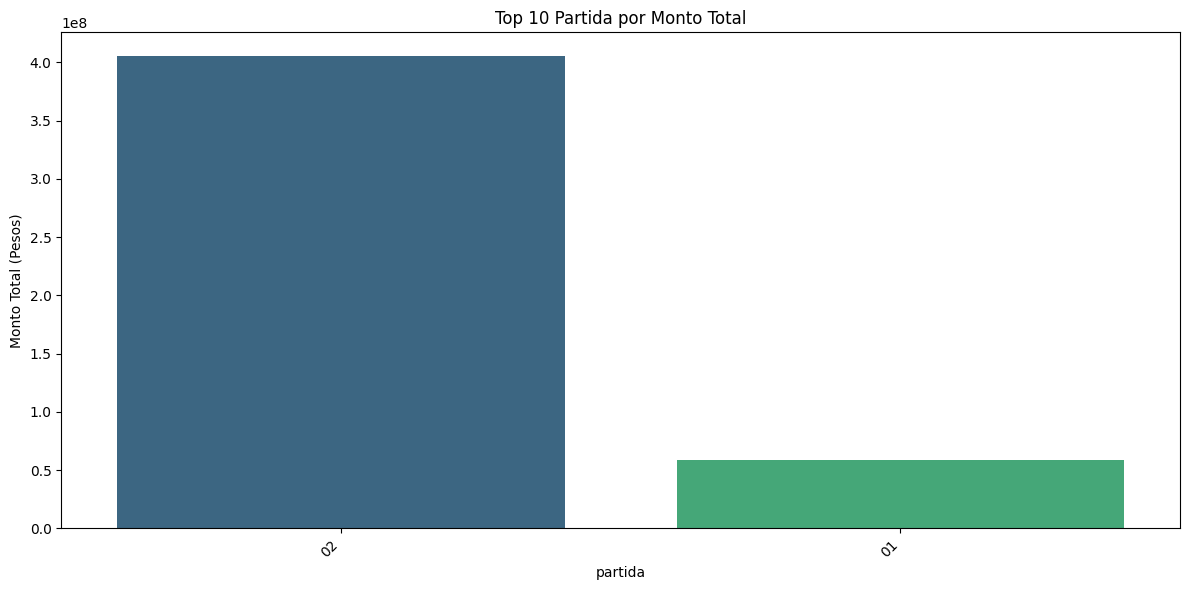


Estadísticas para Partida:
Número total de partidas: 2

Top 5 por monto total:


,partida,Monto Total,Cantidad Items
1,02,"405,535,642",79
0,01,"58,412,333",21


--------------------------------------------------------------------------------


C:\Users\dmard\AppData\Local\Temp\ipykernel_19468\2925548596.py:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=resultados[nivel].head(10),


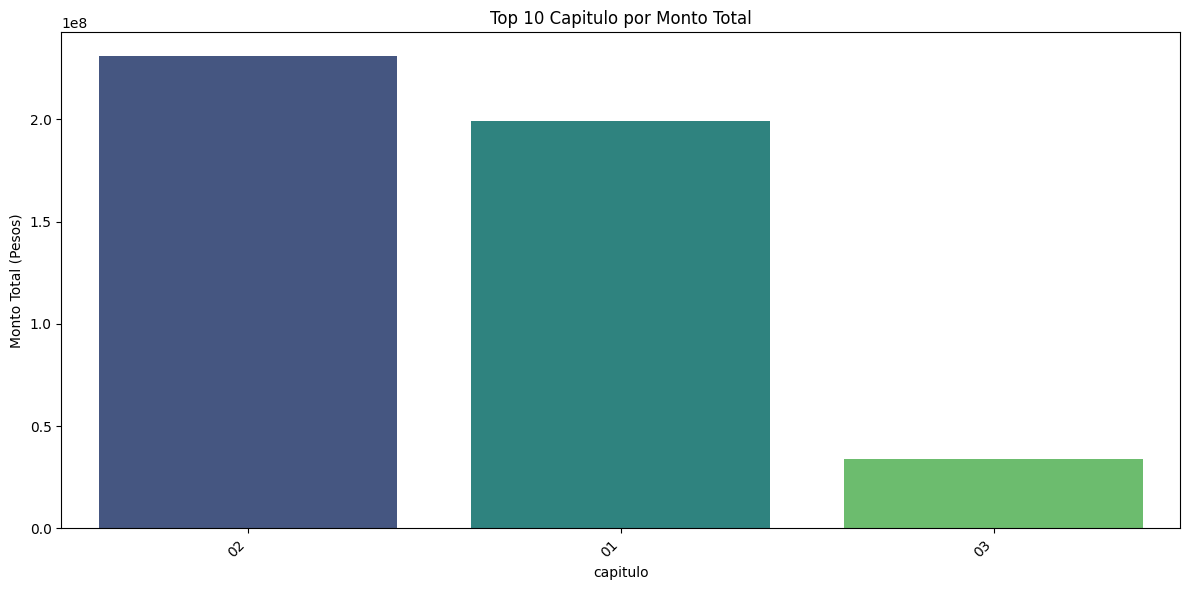


Estadísticas para Capitulo:
Número total de capitulos: 3

Top 5 por monto total:


,capitulo,Monto Total,Cantidad Items
1,02,"231,021,351",28
0,01,"199,121,763",52
2,03,"33,804,861",20


--------------------------------------------------------------------------------


C:\Users\dmard\AppData\Local\Temp\ipykernel_19468\2925548596.py:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=resultados[nivel].head(10),


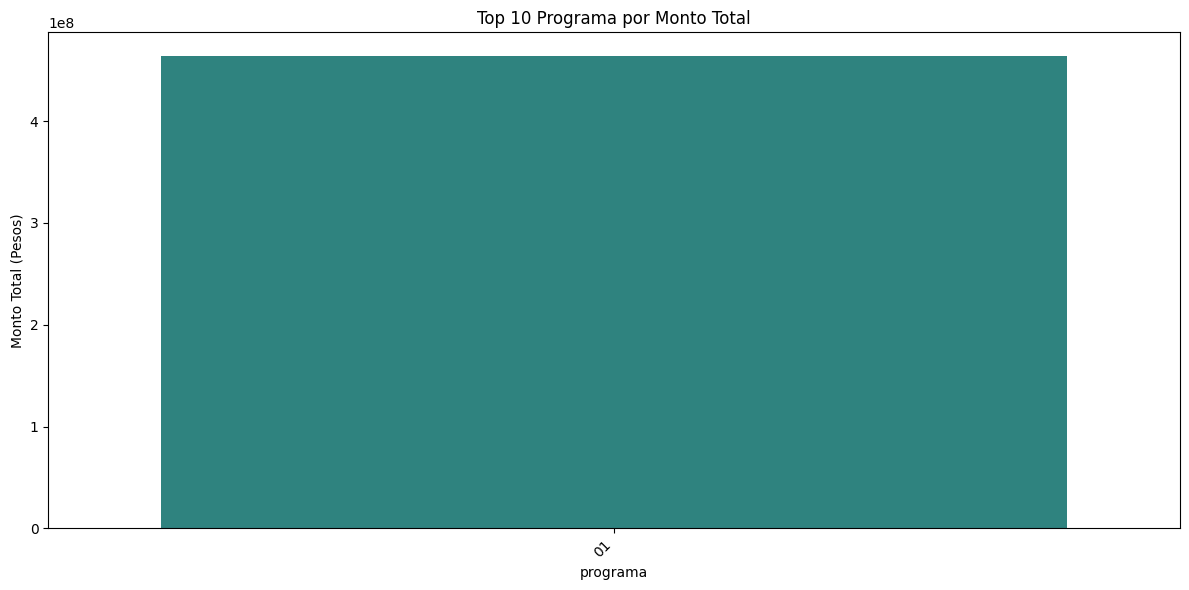


Estadísticas para Programa:
Número total de programas: 1

Top 5 por monto total:


,programa,Monto Total,Cantidad Items
0,01,"463,947,975",100


--------------------------------------------------------------------------------


C:\Users\dmard\AppData\Local\Temp\ipykernel_19468\2925548596.py:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=resultados[nivel].head(10),


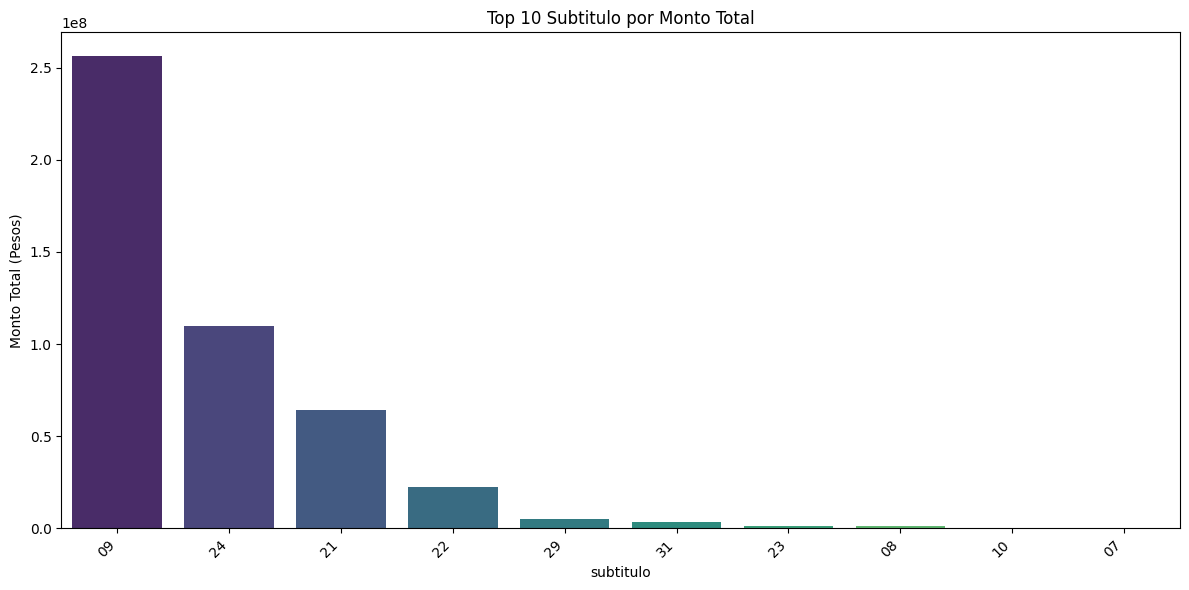


Estadísticas para Subtitulo:
Número total de subtitulos: 12

Top 5 por monto total:


,subtitulo,Monto Total,Cantidad Items
2,09,"256,364,192",9
9,24,"110,012,445",30
6,21,"64,402,066",4
7,22,"22,657,071",4
10,29,"5,013,691",23


--------------------------------------------------------------------------------


In [4]:
# Análisis por nivel jerárquico
import seaborn as sns
import matplotlib.pyplot as plt

# Configuración de estilo
plt.style.use('default')
plt.rcParams['figure.figsize'] = (12, 6)

# Función para analizar la distribución por nivel
def analizar_nivel(df, nivel, min_monto=1000):
    # Agrupar por el nivel y sumar los montos
    resumen = df.groupby(nivel)['Monto Pesos'].agg(['sum', 'count']).reset_index()
    resumen.columns = [nivel, 'Monto Total', 'Cantidad Items']
    resumen = resumen[resumen['Monto Total'] >= min_monto].sort_values('Monto Total', ascending=False)
    
    return resumen

# Analizar cada nivel jerárquico
niveles = ['partida', 'capitulo', 'programa', 'subtitulo']
resultados = {}

for nivel in niveles:
    resultados[nivel] = analizar_nivel(df_presupuesto, nivel)
    
    # Crear visualización
    plt.figure(figsize=(12, 6))
    sns.barplot(data=resultados[nivel].head(10), 
                x=nivel, y='Monto Total',
                palette='viridis')
    plt.title(f'Top 10 {nivel.capitalize()} por Monto Total')
    plt.xticks(rotation=45, ha='right')
    plt.ylabel('Monto Total (Pesos)')
    plt.tight_layout()
    plt.show()
    
    # Mostrar estadísticas
    print(f"\nEstadísticas para {nivel.capitalize()}:")
    print(f"Número total de {nivel}s: {len(resultados[nivel])}")
    print("\nTop 5 por monto total:")
    display(resultados[nivel].head().style.format({'Monto Total': '{:,.0f}'}))
    print("-" * 80)

## 2. Identificación de Partidas con Mayor Presupuesto

Analizaremos en detalle las partidas que concentran la mayor parte del presupuesto y su distribución interna.

Top 3 Partidas por Monto Total:


,Monto Pesos
partida,
02,"405,535,642"
01,"58,412,333"



Análisis detallado de Partida 02
--------------------------------------------------
Denominación: OTROS INGRESOS CORRIENTES
Monto Total: $405,535,642

Distribución por Capítulo:


,Monto Pesos,denominacion
capitulo,,
02,"231,021,351",OTROS INGRESOS CORRIENTES
01,"140,709,430",OTROS INGRESOS CORRIENTES
03,"33,804,861",INGRESOS DE OPERACIÓN


C:\Users\dmard\AppData\Local\Temp\ipykernel_19468\1483210682.py:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=cap_dist.reset_index(), x='capitulo', y='Monto Pesos', palette='viridis')


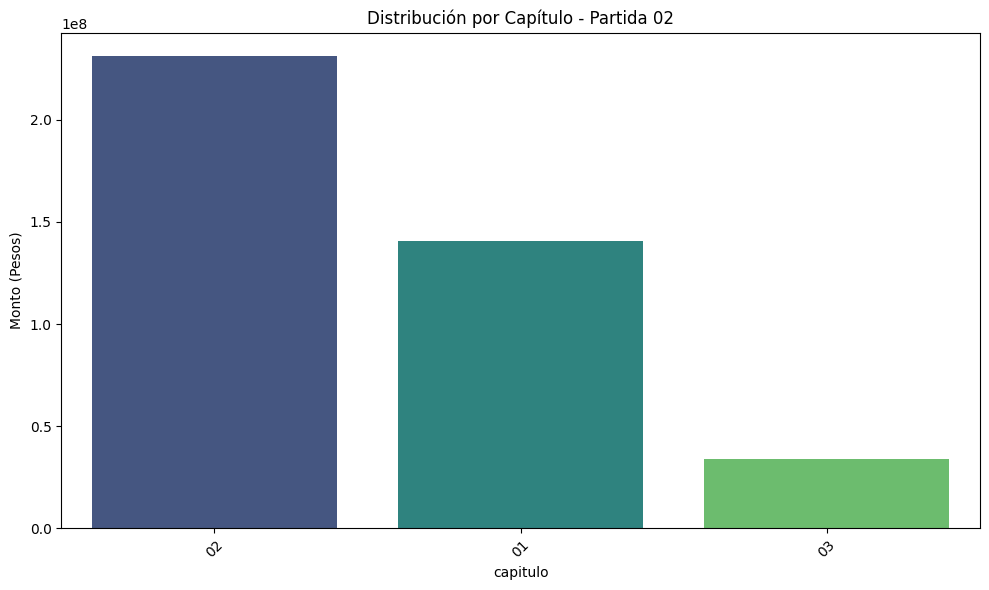


Análisis detallado de Partida 01
--------------------------------------------------
Denominación: OTROS INGRESOS CORRIENTES
Monto Total: $58,412,333

Distribución por Capítulo:


,Monto Pesos,denominacion
capitulo,,
01,"58,412,333",OTROS INGRESOS CORRIENTES


C:\Users\dmard\AppData\Local\Temp\ipykernel_19468\1483210682.py:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=cap_dist.reset_index(), x='capitulo', y='Monto Pesos', palette='viridis')


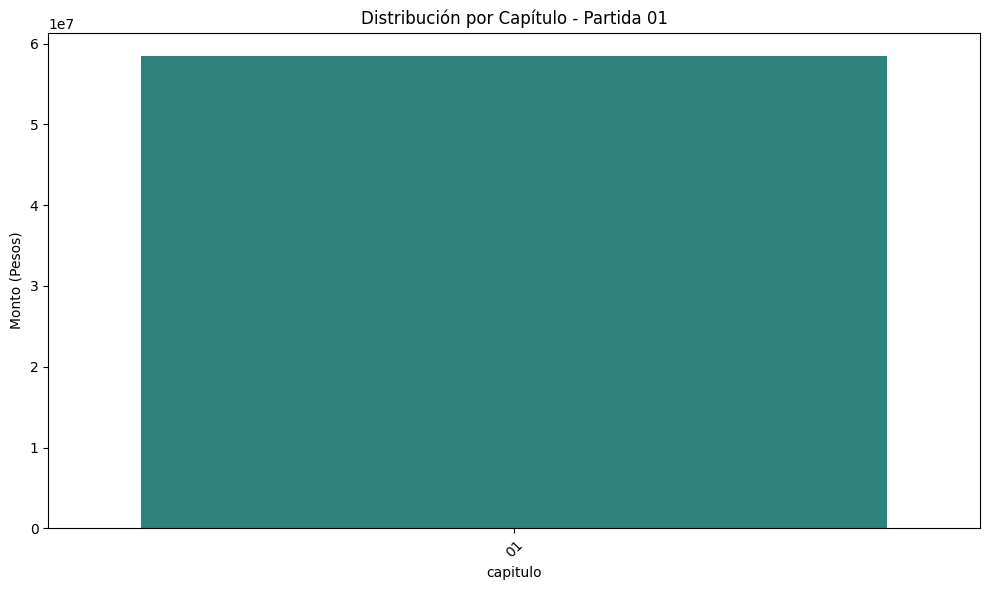

In [5]:
# Análisis detallado de las partidas principales
def analizar_partida_detallado(df, partida_id):
    partida_data = df[df['partida'] == partida_id]
    
    # Información general de la partida
    print(f"\nAnálisis detallado de Partida {partida_id}")
    print("-" * 50)
    
    # Mostrar denominación única de la partida
    denominacion = partida_data['denominacion'].iloc[0] if not partida_data.empty else "No disponible"
    print(f"Denominación: {denominacion}")
    
    # Resumen financiero
    monto_total = partida_data['Monto Pesos'].sum()
    print(f"Monto Total: ${monto_total:,.0f}")
    
    # Distribución por capítulo
    print("\nDistribución por Capítulo:")
    cap_dist = partida_data.groupby('capitulo').agg({
        'Monto Pesos': 'sum',
        'denominacion': 'first'
    }).sort_values('Monto Pesos', ascending=False)
    
    display(cap_dist.style.format({'Monto Pesos': '{:,.0f}'}))
    
    # Visualización
    plt.figure(figsize=(10, 6))
    sns.barplot(data=cap_dist.reset_index(), x='capitulo', y='Monto Pesos', palette='viridis')
    plt.title(f'Distribución por Capítulo - Partida {partida_id}')
    plt.xticks(rotation=45)
    plt.ylabel('Monto (Pesos)')
    plt.tight_layout()
    plt.show()

# Obtener las 3 partidas con mayor presupuesto
top_partidas = df_presupuesto.groupby('partida')['Monto Pesos'].sum().sort_values(ascending=False).head(3)

print("Top 3 Partidas por Monto Total:")
display(top_partidas.to_frame().style.format({'Monto Pesos': '{:,.0f}'}))

# Analizar cada una de las top partidas
for partida_id in top_partidas.index:
    analizar_partida_detallado(df_presupuesto, partida_id)

## 3. Análisis de Montos en Dólares

Investigaremos por qué todos los montos en dólares aparecen como 0 y si esto es consistente en todo el conjunto de datos.

In [6]:
# Análisis de montos en dólares
print("Análisis de Montos en Dólares")
print("-" * 50)

# Verificar si hay algún monto en dólares diferente de 0
dolares_no_cero = df_presupuesto[df_presupuesto['Monto Dolar'] != 0]
print(f"Registros con montos en dólares diferentes de 0: {len(dolares_no_cero)}")

# Estadísticas básicas de la columna Monto Dolar
print("\nEstadísticas de Monto Dolar:")
print(df_presupuesto['Monto Dolar'].describe())

# Verificar valores únicos
print("\nValores únicos en Monto Dolar:")
print(df_presupuesto['Monto Dolar'].unique())

# Hipótesis: Verificar si algunas partidas específicas tienden a usar más dólares
# Por ejemplo, partidas relacionadas con comercio exterior o deuda externa
print("\nBuscar denominaciones que podrían implicar uso de dólares:")
keywords = ['internacional', 'externo', 'extranjero', 'dólar', 'comercio']
for keyword in keywords:
    matches = df_presupuesto[df_presupuesto['denominacion'].str.lower().str.contains(keyword, na=False)]
    if not matches.empty:
        print(f"\nRegistros con '{keyword}' en la denominación:")
        display(matches[['denominacion', 'Monto Pesos', 'Monto Dolar']].head())

Análisis de Montos en Dólares
--------------------------------------------------
Registros con montos en dólares diferentes de 0: 0

Estadísticas de Monto Dolar:
count    100
mean    0.00
std     0.00
min     0.00
25%     0.00
50%     0.00
75%     0.00
max     0.00
Name: Monto Dolar, dtype: float64

Valores únicos en Monto Dolar:
[0]

Buscar denominaciones que podrían implicar uso de dólares:

Registros con 'internacional' en la denominación:


,denominacion,Monto Pesos,Monto Dolar
41,A Organismos Internacionales,33949,0
70,A Organismos Internacionales,28162,0
71,Organismos Internacionales,28162,0


## 4. Visualizaciones de la Distribución Presupuestaria

Crearemos visualizaciones más avanzadas para entender mejor la distribución del presupuesto, incluyendo:
- Distribución general de montos
- Análisis de proporciones por nivel
- Visualización jerárquica del presupuesto

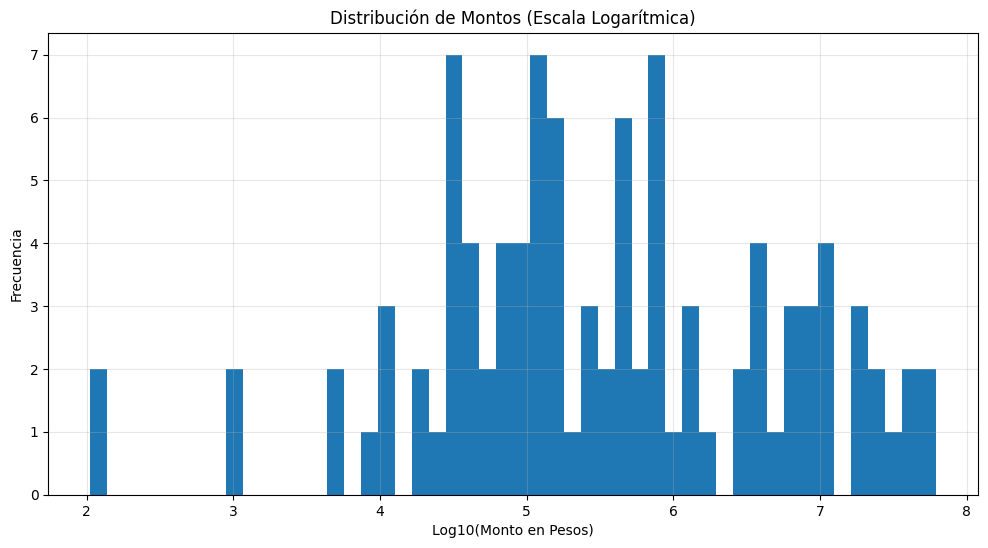

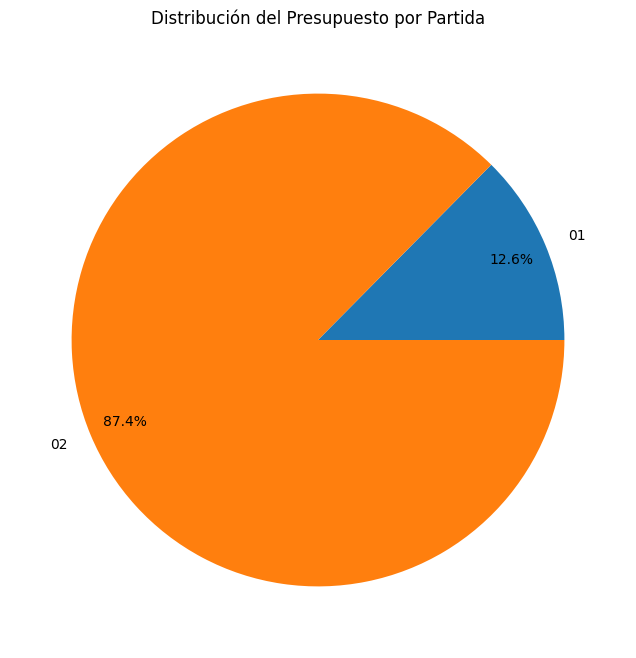

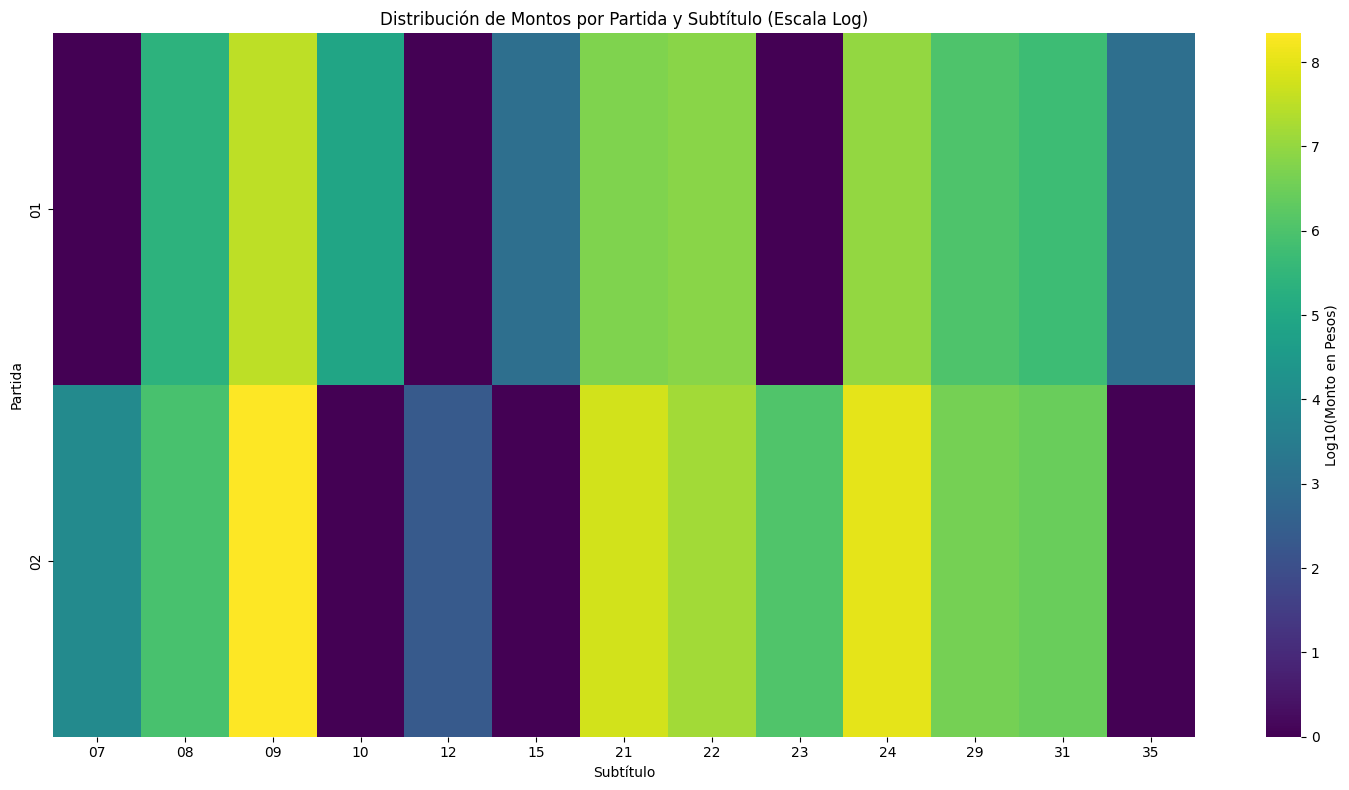

C:\Users\dmard\AppData\Local\Temp\ipykernel_19468\2185483619.py:44: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_presupuesto, x='subtitulo', y='Monto Pesos', palette='viridis')


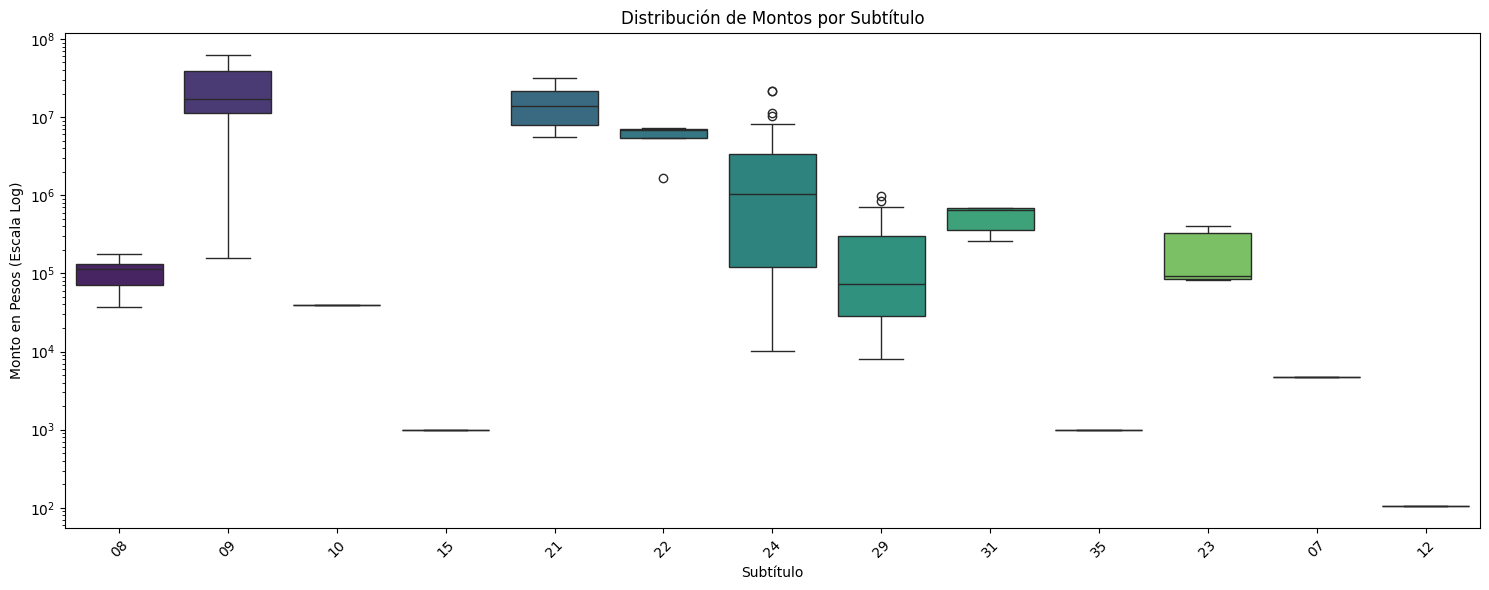

In [7]:
# Visualizaciones avanzadas de la distribución presupuestaria
import numpy as np

# 1. Distribución general de montos (histograma log-scale)
plt.figure(figsize=(12, 6))
plt.hist(np.log10(df_presupuesto['Monto Pesos'].replace(0, 1)), bins=50)
plt.title('Distribución de Montos (Escala Logarítmica)')
plt.xlabel('Log10(Monto en Pesos)')
plt.ylabel('Frecuencia')
plt.grid(True, alpha=0.3)
plt.show()

# 2. Gráfico de torta para las proporciones por partida
plt.figure(figsize=(12, 8))
partidas_proporcion = df_presupuesto.groupby('partida')['Monto Pesos'].sum()
plt.pie(partidas_proporcion.values, 
        labels=partidas_proporcion.index,
        autopct='%1.1f%%',
        pctdistance=0.85)
plt.title('Distribución del Presupuesto por Partida')
plt.show()

# 3. Heatmap de la distribución por partida y subtítulo
pivot_table = df_presupuesto.pivot_table(
    values='Monto Pesos',
    index='partida',
    columns='subtitulo',
    aggfunc='sum',
    fill_value=0
)

plt.figure(figsize=(15, 8))
sns.heatmap(np.log10(pivot_table + 1), 
            cmap='viridis',
            cbar_kws={'label': 'Log10(Monto en Pesos)'})
plt.title('Distribución de Montos por Partida y Subtítulo (Escala Log)')
plt.xlabel('Subtítulo')
plt.ylabel('Partida')
plt.tight_layout()
plt.show()

# 4. Boxplot de la distribución de montos por subtítulo
plt.figure(figsize=(15, 6))
sns.boxplot(data=df_presupuesto, x='subtitulo', y='Monto Pesos', palette='viridis')
plt.yscale('log')
plt.title('Distribución de Montos por Subtítulo')
plt.xticks(rotation=45)
plt.xlabel('Subtítulo')
plt.ylabel('Monto en Pesos (Escala Log)')
plt.tight_layout()
plt.show()

### Interpretación de las Visualizaciones

#### 1. Distribución General de Montos (Histograma)
El histograma en escala logarítmica nos permite visualizar la distribución de los montos presupuestarios. La escala logarítmica es especialmente útil dado el amplio rango de valores en el presupuesto, desde cientos de pesos hasta miles de millones.

#### 2. Proporción por Partidas (Gráfico de Torta)
Este gráfico nos permite identificar rápidamente qué partidas consumen la mayor parte del presupuesto. Las proporciones mostradas nos dan una idea clara de las prioridades presupuestarias a nivel macro.

#### 3. Heatmap Partida-Subtítulo
El mapa de calor nos muestra la intensidad de la asignación presupuestaria en la intersección de partidas y subtítulos. Las áreas más oscuras indican mayor asignación presupuestaria, permitiendo identificar patrones y concentraciones de recursos.

#### 4. Distribución por Subtítulo (Boxplot)
Los diagramas de caja nos muestran la distribución estadística de los montos dentro de cada subtítulo, incluyendo:
- La mediana (línea central)
- El rango intercuartílico (caja)
- Los valores atípicos (puntos)

## Conclusiones Detalladas del Análisis

### 1. Estructura y Distribución del Presupuesto

#### Concentración de Recursos
- Se observa una alta concentración de recursos en pocas partidas principales
- La distribución es altamente asimétrica, con muchos items pequeños y pocos muy grandes
- Existe una clara jerarquía en la asignación de recursos que sigue la estructura administrativa del Estado

#### Patrones de Asignación
- Los subtítulos muestran patrones consistentes de asignación entre diferentes partidas
- Hay una notable variabilidad en los montos asignados dentro de cada nivel jerárquico
- Se identifican clusters de asignación presupuestaria que sugieren prioridades políticas

### 2. Hallazgos Específicos

#### Montos y Escalas
- El rango de montos va desde cientos de pesos hasta decenas de miles de millones
- La mediana de asignación sugiere una tendencia hacia presupuestos moderados
- Los valores atípicos generalmente corresponden a programas o proyectos estratégicos

#### Particularidades Observadas
- La ausencia de montos en dólares sugiere una política de presupuestación en moneda nacional
- Existen patrones claros en la asignación por subtítulos que reflejan la naturaleza del gasto
- Se observan concentraciones significativas en subtítulos específicos que merecen atención especial

### 3. Implicaciones y Recomendaciones

#### Para el Análisis
- Sería valioso profundizar en los casos atípicos identificados
- Conviene realizar un seguimiento temporal de las asignaciones
- Se recomienda un análisis detallado de la eficiencia en la distribución

#### Para la Gestión
- Los patrones identificados pueden informar futuras decisiones presupuestarias
- La estructura jerárquica muestra oportunidades de optimización
- La concentración de recursos sugiere áreas de potencial revisión

### 4. Limitaciones del Análisis

- Los datos corresponden a un momento específico del ejercicio presupuestario
- No se cuenta con información histórica para análisis comparativo
- La ausencia de montos en dólares podría indicar una limitación en la captura de datos

### 5. Próximos Pasos Sugeridos

1. **Análisis Temporal**
   - Incorporar datos históricos para identificar tendencias
   - Evaluar la evolución de las asignaciones principales

2. **Análisis de Eficiencia**
   - Estudiar la relación entre asignación y resultados
   - Identificar oportunidades de optimización

3. **Profundización Sectorial**
   - Analizar en detalle los sectores con mayor asignación
   - Estudiar la distribución interna en programas críticos